<a href="https://colab.research.google.com/github/torodriguezt/Vision_Artificial/blob/main/trabajoFinalVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1><center>Trabajo Final Visión Artificial </center></h1>**

**<h1><center> 2022-2s </center></h1>**
---


---


# Programa para reconocer si la imagen es una Pizza

---


## Integrantes:

*   Juan Alejandro Espinosa Cáceres
*   Andrés Felipe Rendón Henao
*   Jose Adolfo Martínez Rodríguez
*   Juan Sebastián Herrera Gómez
*   Tomás Rodríguez Taborda




### Importamos Librerías

In [483]:
import math
import pandas as pd
import numpy as np
import cv2
import os
import seaborn as sns
from skimage import morphology
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import skimage.morphology as morph
from google.colab import drive

### Cargamos las imágenes desde Drive

In [484]:
drive.mount("/content/drive")
path_pizza = "/content/drive/MyDrive/Vision/pizza_not_pizza/pizza"
path_not_pizza = "/content/drive/MyDrive/Vision/pizza_not_pizza/not_pizza"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [485]:
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

### Hacemos una lectura de las imágenes a color para ver como esta compuesto nuestro dataset

In [486]:
pizzas_color = []
not_pizzas_color = []

for img in os.listdir(path_pizza):
    img = cv2.imread(os.path.join(path_pizza,img))
    img_resize= cv2.resize(img,(100,100))
    pizzas_color.append(img_resize)

for img in os.listdir(path_not_pizza):
    img = cv2.imread(os.path.join(path_not_pizza,img))
    img_resize= cv2.resize(img,(100,100))
    not_pizzas_color.append(img_resize)

In [487]:
pizzas_color = np.array(pizzas_color)
not_pizzas_color = np.array(not_pizzas_color)

### Miramos como esta compuesto nuestro dataset

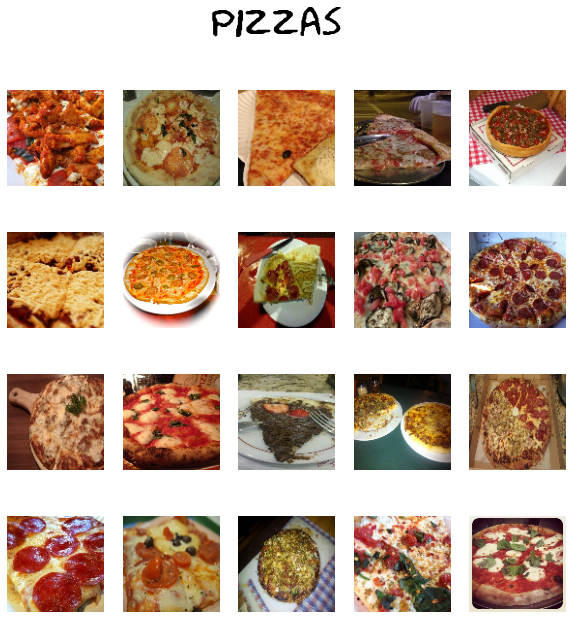

In [488]:
fig, ax = plt.subplots(4,5, figsize = (10,10))
im = 0
csfont = {'fontname':'Humor Sans'}
fig.suptitle('Pizzas', fontsize=40, weight = "bold", **csfont)

for i in range (0,4):
  for j in range (0,5):
    ax[i,j].imshow(cv2.cvtColor(pizzas_color[j+im], cv2.COLOR_BGR2RGB))
    ax[i,j].set_axis_off()
  im += 5

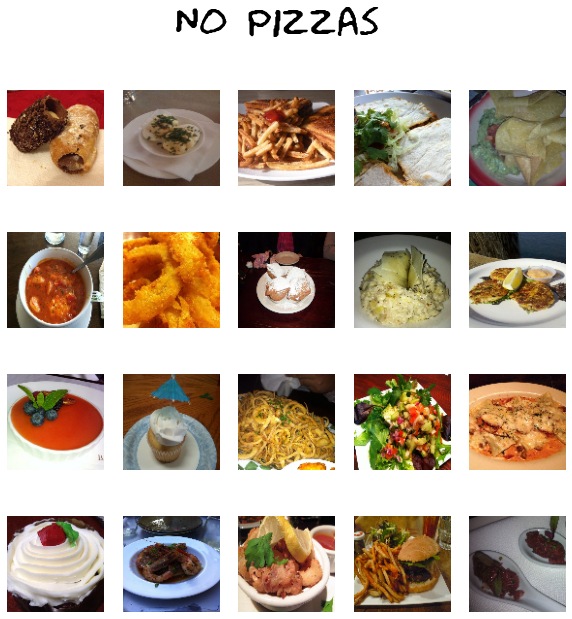

In [489]:
fig, ax = plt.subplots(4,5, figsize = (10,10))
im = 0
csfont = {'fontname':'Humor Sans'}
fig.suptitle('No Pizzas', fontsize=40, weight = "bold", **csfont)

for i in range (0,4):
  for j in range (0,5):
    ax[i,j].imshow(cv2.cvtColor(not_pizzas_color[j+im], cv2.COLOR_BGR2RGB))
    ax[i,j].set_axis_off()
  im += 5

### Ahora hacemos la lectura de nuestro dataset en escala de grises 

In [490]:
pizzas= []
not_pizzas = []

for img in os.listdir(path_pizza):
    img = img_read(os.path.join(path_pizza,img), "gray")
    img_resize= cv2.resize(img,(100,100))
    pizzas.append(img_resize)

for img in os.listdir(path_not_pizza):
    img = img_read(os.path.join(path_not_pizza,img), "gray")
    img_resize= cv2.resize(img,(100,100))
    not_pizzas.append(img_resize)

pizzas = np.array(pizzas)
not_pizzas = np.array(not_pizzas)

### Empezamos a buscar un canal que nos permita entender donde ocurre la separación de elementos de la manera más notable

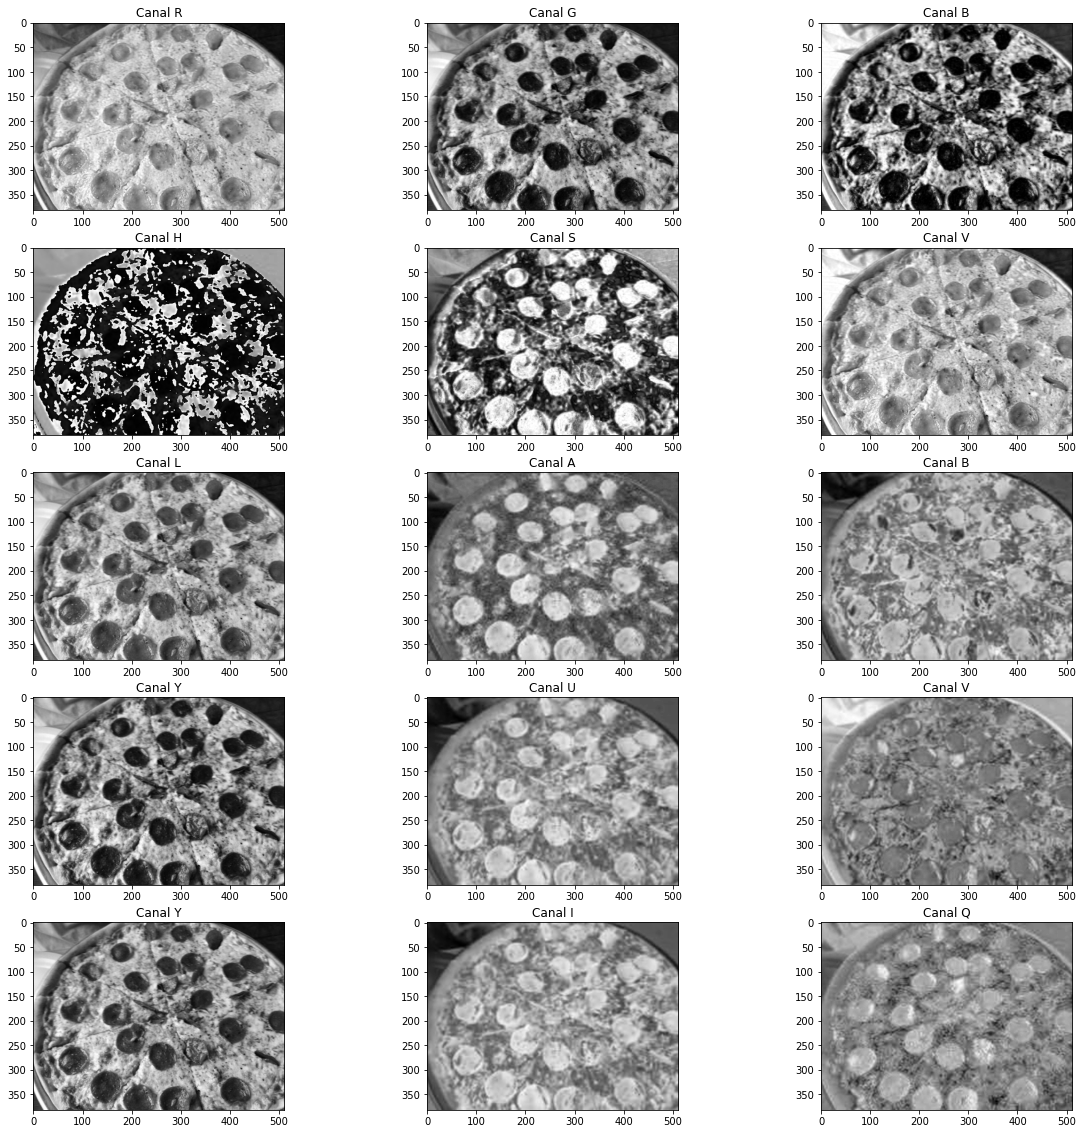

In [491]:
img = cv2.imread("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg")
fig, ax = plt.subplots(5,3, figsize = (20,20))
#RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ax[0,0].imshow(img_rgb[:,:,0], cmap = "gray")
ax[0,0].set_title("Canal R")
ax[0,1].imshow(img_rgb[:,:,1], cmap = "gray")
ax[0,1].set_title("Canal G")
ax[0,2].imshow(img_rgb[:,:,2], cmap = "gray")
ax[0,2].set_title("Canal B")

#HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

ax[1,0].imshow(img_hsv[:,:,0], cmap = "gray")
ax[1,0].set_title("Canal H")
ax[1,1].imshow(img_hsv[:,:,1], cmap = "gray")
ax[1,1].set_title("Canal S")
ax[1,2].imshow(img_hsv[:,:,2], cmap = "gray")
ax[1,2].set_title("Canal V")

#LAB
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

ax[2,0].imshow(img_lab[:,:,0], cmap = "gray")
ax[2,0].set_title("Canal L")
ax[2,1].imshow(img_lab[:,:,1], cmap = "gray")
ax[2,1].set_title("Canal A")
ax[2,2].imshow(img_lab[:,:,2], cmap = "gray")
ax[2,2].set_title("Canal B")

#YUV
img_yuv  = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

ax[3,0].imshow(img_yuv[:,:,0], cmap = "gray")
ax[3,0].set_title("Canal Y")
ax[3,1].imshow(img_yuv[:,:,1], cmap = "gray")
ax[3,1].set_title("Canal U")
ax[3,2].imshow(img_yuv[:,:,2], cmap = "gray")
ax[3,2].set_title("Canal V")

#YIQ

img_Y = 0.299*img_rgb[:,:,0]+0.587*img_rgb[:,:,1]+0.144*img_rgb[:,:,2]
img_I = 0.596*img_rgb[:,:,0]-0.274*img_rgb[:,:,1]-0.322*img_rgb[:,:,2]
img_Q = 0.211*img_rgb[:,:,0]-0.523*img_rgb[:,:,1]+0.312*img_rgb[:,:,2]

ax[4,0].imshow(img_Y, cmap = "gray")
ax[4,0].set_title("Canal Y")
ax[4,1].imshow(img_I, cmap = "gray")
ax[4,1].set_title("Canal I")
ax[4,2].imshow(img_Q, cmap = "gray")
_ = ax[4,2].set_title("Canal Q")

# Extracción de características


Creamos un dataframe con las variables que pensamos extraer inicialmente de nuestras imágenes

In [492]:
datos = pd.DataFrame()
datos["Area"] = None
datos["Perimetro"] = None
datos["Pepperoni"] = None
datos["Etiqueta"] = None

Definimos una función que nos permitirá separar las características buscadas de cada una de las imágenes. Para hallar el área utilizaremos countourArea(), para el perímetro utilizaremos arcLength() que nos permite hallar el perímetro del contorno y para hallar los pepperonis que estan en la pizza usaremos el canal A del LAB y utilizando morfología trateremos de hallar las figuras más similares a esta.

In [493]:
def feature_extractor(filename, label):
    '''
    Parámetros de entrada:
    filename : ruta del archivo que queremos procesar

    Parámetros de salida:
    l : Vector de características
    '''

    try:
        main_img = cv2.imread(filename)
        img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    except:
        return "Invalid"

    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25), 0)

    ret_otsu,im_bw_otsu = cv2.threshold(blur, 0, 255, 
                                        cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 
    kernel = np.ones((25,25), np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

    # Area y perímetro
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    area = cv2.contourArea(cnt)
    if area==0:
        return "Invalid"
    perimeter = cv2.arcLength(cnt,True)

    current_frame = main_img
    filtered_image = closing/255

    img = cv2.imread(filename)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) #La volvemos a leer para usar el canal A

    _, thresh_1 = cv2.threshold(img1[:,:,1], 160, 255, cv2.THRESH_BINARY)

    kernel = morph.disk(5)
    apertura = cv2.morphologyEx(thresh_1, cv2.MORPH_OPEN, kernel, iterations = 2)

    contours, hierarchy = cv2.findContours(apertura.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    l = [area, perimeter, len(contours), label]
    return l

Hacemos el llamado de la función que definimos arriba para cada uno de los sets de imágenes que tenemos (pizzas y no pizzas) para extraer sus características, las cuales serán guardas en una lista para posteriormente ser pasadas a un dataset. También quitaremos aquellas imágenes en las cuales no fue posible hacer su lectura y que fueron clasificadas como "Invalid"

In [494]:
total_carac = []

for img in os.listdir(path_pizza):
  caracteristicas = feature_extractor(f"/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/{img}", "Pizza")
  total_carac.append(caracteristicas)

for img in os.listdir(path_not_pizza):
  caracteristicas = feature_extractor(f"/content/drive/MyDrive/Vision/pizza_not_pizza/not_pizza/{img}", "No Pizza")
  total_carac.append(caracteristicas)


In [495]:
total = len(total_carac)
for i in range(total):
  datos.loc[len(datos)] = total_carac[i]

datos = datos.drop(datos[datos["Etiqueta"] == "Invalid"].index)

In [496]:
datos

,Area,Perimetro,Pepperoni,Etiqueta
0,230935.5,2291.747254,23,Pizza
1,2373.5,258.183766,0,Pizza
2,199744.0,2291.837658,22,Pizza
3,224403.0,3212.690468,2,Pizza
4,693.0,127.112698,7,Pizza
...,...,...,...,...
1961,111.5,42.384776,1,No Pizza
1962,10.0,12.828427,1,No Pizza
1963,210.0,54.627416,0,No Pizza
1964,237.0,68.627417,9,No Pizza


Miramos el resultado del dataframe que acabamos de crear 

Guardamos el anterior dataset creado como un archivo excel que nos permitirá facilitar la creación de gráficas para la parte de aprendizaje del programa

In [497]:
datos.to_excel("Clasificacion.xlsx")

# Modelo de Clasificación

### Empezamos tratando decidir cual es el mejor modelo de clasificación para el problema

### Importamos librerías

In [498]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Leemos el excel que creamos anteriormente debido a que facilita crear el scatter plot de más abajo

In [499]:
datos_excel = pd.read_excel("Clasificacion.xlsx", index_col=0)

Para clasificación de las imágenes dentro del modelo, y graficar cada una de las características separamos nuestro dataframe entre toda la información extraída en una varibale y su clasificación en otra

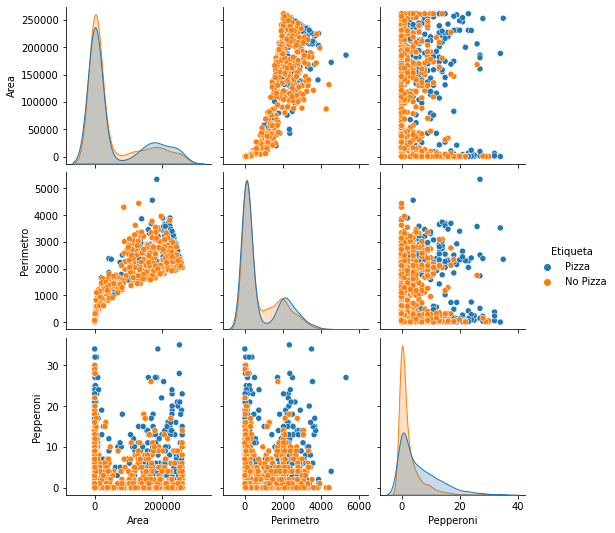

In [500]:
_ = sns.pairplot(datos_excel, hue="Etiqueta")

Con el gráfico anterior podemos ver que debemos descartar el método de los k-veciones más cercanos, nuestro set de entrenamiento no esta lo suficientemente disperso entre si en los criterios que utilizamos para que este método haga predicciones de manera eficiente

In [501]:
informacion = datos_excel.drop("Etiqueta", axis = 1)
target = datos_excel["Etiqueta"]

In [502]:
informacion = np.array(informacion)
target = np.array(target)

# Algoritmos de Aprendizaje

In [503]:
X_train, X_test, y_train, y_test = train_test_split(informacion, target, random_state=42)

Viendo los datos que tenemos utilizaremos el algoritmo de Random Forest para lograr un aprendizaje de manera eficiente.

Separamos la información que tenemos hasta el momento en dos, una para entrenar el modelo y otra para validar que funcione correctamente. Utilizaremos el 75% para entrenar y el 25% para validar el modelo

### Tree Classifier

In [504]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [505]:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.624


### Forest Classifier

In [506]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

In [507]:
predictions = forest.predict(X_test)

In [508]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.934
Accuracy on test set: 0.647


### Red Neuronal Convolucional

In [509]:
!pip install -q tfds-nightly
!tfds --version

TensorFlow Datasets: 4.7.0+nightly


In [510]:
images = np.array(np.concatenate([pizzas, not_pizzas]))
labels = np.array(np.concatenate([np.repeat(0,len(pizzas)),np.repeat(1,len(not_pizzas))]))

In [511]:
import tensorflow as tf
modeloCNN2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100,1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [512]:
modeloCNN2.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [513]:
print(y_train)

['No Pizza' 'No Pizza' 'No Pizza' ... 'Pizza' 'No Pizza' 'No Pizza']


In [514]:
from tensorflow.keras.callbacks import TensorBoard
tensorboardDenso = TensorBoard(log_dir='logs/denso')
modeloCNN2.fit(images, labels, batch_size=32,
                validation_split=0.15,
                epochs=20,
                callbacks=[tensorboardDenso])

Epoch 1/20
53/53 [==============================] - 67s 1s/step - loss: 10.8142 - accuracy: 0.5667 - val_loss: 0.6197 - val_accuracy: 0.8102
Epoch 2/20
53/53 [==============================] - 38s 720ms/step - loss: 0.6523 - accuracy: 0.6158 - val_loss: 1.0370 - val_accuracy: 0.1017
Epoch 3/20
53/53 [==============================] - 40s 755ms/step - loss: 0.6228 - accuracy: 0.6505 - val_loss: 0.7300 - val_accuracy: 0.4983
Epoch 4/20
53/53 [==============================] - 34s 642ms/step - loss: 0.5971 - accuracy: 0.6882 - val_loss: 0.3606 - val_accuracy: 0.9085
Epoch 5/20
53/53 [==============================] - 33s 623ms/step - loss: 0.5373 - accuracy: 0.7331 - val_loss: 1.2127 - val_accuracy: 0.3356
Epoch 6/20
53/53 [==============================] - 33s 623ms/step - loss: 0.5078 - accuracy: 0.7451 - val_loss: 0.6695 - val_accuracy: 0.6407
Epoch 7/20
53/53 [==============================] - 32s 609ms/step - loss: 0.5058 - accuracy: 0.7522 - val_loss: 0.7711 - val_accuracy: 0.5932
E

(1, 100, 100)
1/1 [==============================] - 0s 97ms/step
[[0.01919364 0.98080635]]
1.0
1
prediccion: no pizza


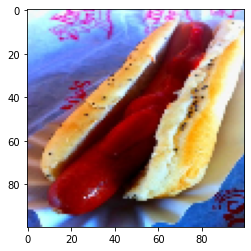

In [515]:
papizza="/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/254812.jpg"
panotpizza="/content/drive/MyDrive/Vision/pizza_not_pizza/not_pizza/160274.jpg"

img = cv2.imread(panotpizza)
img = cv2.resize(img, (100,100))
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imglist=[]
imglist.append(img_gray)

imglist = np.array(imglist)
print(imglist.shape)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

predictions = modeloCNN2.predict(imglist)
print(predictions)
print(np.sum(predictions))
print(np.argmax(predictions))
if(np.argmax(predictions)==1):
  print("prediccion: no pizza")
else:
  print("prediccion: pizza")